<a href="https://colab.research.google.com/github/mlej8/ECSE552/blob/main/Tutorials/Tutorial3_Regularization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pattern Matching with Parameter Sharing and regularizations

Goals:
* Create a model that will look at two images and evaluate whether they are the same.
* implement a Siamese neural network
* implement different regularizations in the siamese network


In particular we will try to identify which images match in the USPS and MNIST Dataset.
Given sample $a$ from MNIST and sample $b$ from USPS, are they the same number?

In [ ]:
from torchvision import datasets
import torchvision.transforms as transforms
import torch
import numpy as np

## Load the USPS Dataset

In [ ]:
transform = transforms.Compose(
    [transforms.ToTensor()])
usps_trainset = datasets.USPS(root='./data', train=True, download=True, transform=transform)
usps_testset = datasets.USPS(root='./data', train=False, download=True, transform=transform)

In [ ]:
usps_trainset[0][0].shape

torch.Size([1, 16, 16])

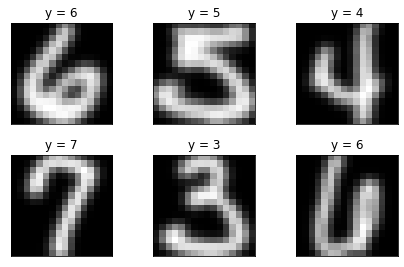

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(usps_trainset[i][0].reshape(16,16), cmap='gray', interpolation='none')
  plt.title("y = {}".format(usps_trainset[i][1]))
  plt.xticks([])
  plt.yticks([])

## Load the MNIST Dataset

In [ ]:
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [ ]:
mnist_trainset[0][0].shape

torch.Size([1, 28, 28])

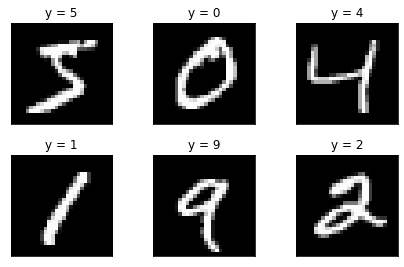

In [ ]:
fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(mnist_trainset[i][0].reshape(28,28), cmap='gray', interpolation='none')
  plt.title("y = {}".format(mnist_trainset[i][1]))
  plt.xticks([])
  plt.yticks([])

## Create the Dataloaders

In [ ]:
train_mnist = torch.utils.data.DataLoader(mnist_trainset, batch_size=128, shuffle=True, drop_last=True)
train_usps = torch.utils.data.DataLoader(usps_trainset, batch_size=128, shuffle=True, drop_last=True)

To get a picture of what is happening, we are going to create a dummy validation set.

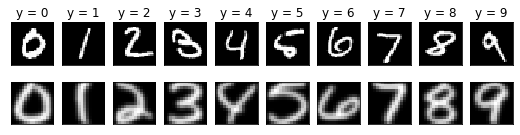

In [ ]:
def get_dummy_val(dataset, size):
    dummy_val = torch.Tensor(10, size, size)
    idx = np.ones(10, dtype=int)*-1
    count = 0
    for i, x in enumerate(dataset):
        if idx[x[1]] != -1:
            continue
        else:
            idx[x[1]] = i
            dummy_val[x[1]] = x[0]
            count += 1
        if count == 10:
            break
    return dummy_val

mnist_val = get_dummy_val(mnist_testset, 28)
usps_val = get_dummy_val(usps_testset, 16)

fig, axes = plt.subplots(2, 10, figsize=(9,2))
for i in range(10):
    ax = axes[0][i%10]
    ax.imshow(mnist_val[i].reshape(28,28), cmap='gray', interpolation='none')
    ax.set_title("y = {}".format(i))
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = axes[1][i%10]
    ax.imshow(usps_val[i].reshape(16,16), cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])

In [ ]:
mnist_val = mnist_val.view(10,-1).unsqueeze(1) #(10, 1, 28*28)
usps_val = usps_val.view(10,-1).unsqueeze(0) #(1, 10, 16*16)

mnist_val = mnist_val.repeat(1,10,1) #(10,10,28*28)
usps_val = usps_val.repeat(10,1,1)   #(10,10,16*16)

val = torch.cat([mnist_val, usps_val],-1).reshape(100,-1)
mnist_val = val[:,:28*28]
usps_val = val[:,28*28:]

In [ ]:
print(val.shape)

torch.Size([100, 1040])


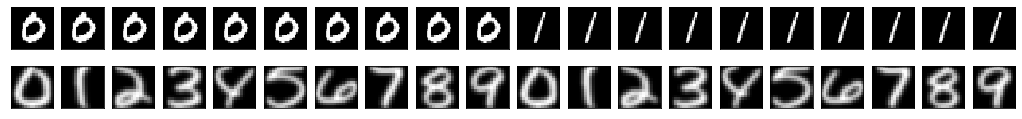

In [ ]:
fig, axes = plt.subplots(2, 20, figsize=(18, 2))
for i in range(20):
    ax = axes[0][i]
    ax.imshow(mnist_val[i].reshape(28,28), cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
    
    ax = axes[1][i]
    ax.imshow(usps_val[i].reshape(16,16), cmap='gray', interpolation='none')
    ax.set_xticks([])
    ax.set_yticks([])
# plt.tight_layout()

In [ ]:
val_label = torch.eye(10).reshape(-1)
np_val_label = np.eye(10, dtype=int).reshape(-1) # just so we do not keep on changing the datatype of this

## Training Loop

Let's create the training loop beforehand because we will experiment with different regularizations. Since the dataset is imbalaced (about 1/10 of the samples match in each batch if we sample independently from both datasets), we are going to use the AUC as the validation metric.

In [ ]:
import sklearn.metrics as metrics

def train(model, data1, data2, val_data, num_epoch, loss_func, optimizer, device):
    for i in range(num_epoch):
        model.train()
        data = zip(data1, data2)
        for (x1, y1), (x2, y2) in data:        
            # move the data to gpu
            x1, x2 = x1.to(device), x2.to(device) 
            y = ((y1 == y2)*1.0).view(-1,1).to(device) # 1 if they match, 0 otherwise
    
            # reset the gradients
            optimizer.zero_grad() 
            # x1.shape = (batch, 1, 28,28)
            y_hat = model(x1.view(-1, 28*28), x2.view(-1, 16*16))
            batch_loss = loss_func(y_hat, y, model)
            batch_loss.backward() # autodiff
            optimizer.step() # weight update
        
        model.eval()
        with torch.no_grad():
            pred = model(val_data[0].to(device), val_data[1].to(device))
            val_loss = loss_func(pred, val_label.to(device), model)
            pred = pred[0].detach().cpu().numpy() 

            fpr, tpr, thresholds = metrics.roc_curve(np_val_label,pred.reshape(-1))
            auc = metrics.auc(fpr, tpr)
            
        print(i, batch_loss.item(), val_loss.item(), auc)
    return model

# Create our matching neural networks

One way of pattern matching is to simply create 2 parallel neural networks and then concatene the representation learned at some point. You can then formulate this as a binary classification problem like the example below:

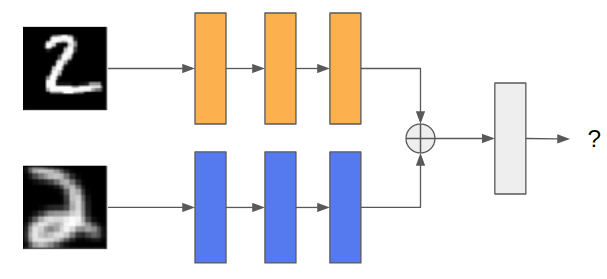

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MatchingNetworkV1(nn.Module):
    def __init__(self, mnist_in, usps_in):
        super(MatchingNetworkV1, self).__init__()
        self.layer1_mnist = nn.Linear(mnist_in, 64)
        self.layer1_usps = nn.Linear(usps_in, 64)
        
        self.layer2_mnist = nn.Linear(64, 32)
        self.layer2_usps = nn.Linear(64, 32)
        
        self.layer3_mnist = nn.Linear(32, 16)
        self.layer3_usps = nn.Linear(32, 16)
        
        self.out = nn.Linear(32,1)
    
    def forward(self, x1, x2):
        x1 = F.relu(self.layer1_mnist(x1))
        x1 = F.relu(self.layer2_mnist(x1))
        x1 = F.relu(self.layer3_mnis(x1))
        
        x2 = F.relu(self.layer1_usps(x2))
        x2 = F.relu(self.layer2_usps(x2))
        x2 = F.relu(self.layer3_usps(x2))
        return self.out(torch.cat([x1,x2], -1))

The one above is a viable option but it is prone to overfitting due to overparametrization. Furthermore, it does not take advantage of the fact that higher-level representations of the features may have similar patterns and thus we can share the parameters like the example below.

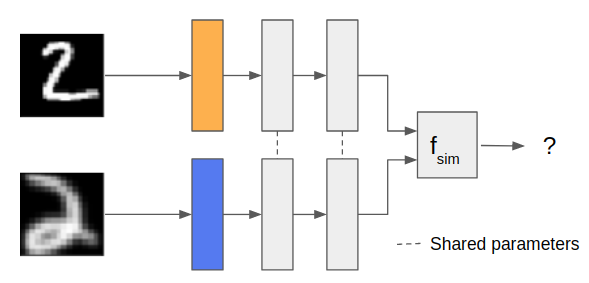

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class MatchingNetwork(nn.Module):
    def __init__(self, mnist_in, usps_in):
        super(MatchingNetwork, self).__init__()
        self.layer1_mnist = nn.Linear(mnist_in, 128)
        self.layer1_usps = nn.Linear(usps_in, 128)
        
        self.layer2 = nn.Linear(128, 64) # shared between the mnist and usps track
        self.layer3 = nn.Linear(64, 32) # shared between the mnist and usps track
    
    def forward(self, x1, x2):
        x1 = F.relu(self.layer1_mnist(x1))
        x1 = F.relu(self.layer2(x1))
        x1 = torch.tanh(self.layer3(x1))
        
        x2 = F.relu(self.layer1_usps(x2))
        x2 = F.relu(self.layer2(x2))
        x2 = torch.tanh(self.layer3(x2))
        return F.cosine_similarity(x1,x2), x1, x2

In the NN above, we can see that instead of having a single output layer, we used the cosine similarity of the embeddings of the two inputs say $\hat{x}_a$ and $\hat{x}_b$. 

$sim(\hat{x}_a, \hat{x}_b) \in [-1,1]$, which we can interpret as follows:
*  $sim(\hat{x}_a, \hat{x}_b) = -1$: the embeddings go on opposite ways
*  $sim(\hat{x}_a, \hat{x}_b) = 0$: the embeddings are orthogonal
*  $sim(\hat{x}_a, \hat{x}_b) = 1$: the embeddings are pointed towards the same direction

With that, a simplification to a binary task would be to set $0$ as the threshold.

Loss function and Optimizer

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [ ]:
model = MatchingNetwork(28*28, 16*16)
model = model.to(device)
cosemb = nn.CosineEmbeddingLoss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [ ]:
def loss_func(y_hat, y, model):
    y2 = y + 1*(y-1) # convert 0's to -1's
    loss = cosemb(y_hat[1], y_hat[2], y2.reshape(-1))
    return loss

 Let us train model...

In [ ]:
m = train(model, train_mnist, train_usps, [mnist_val, usps_val], 50, loss_func, optimizer, device)


0 14.315871238708496 10.259416580200195 0.6433333333333333
1 8.138701438903809 10.070667266845703 0.6888888888888889
2 5.051932334899902 10.032842636108398 0.6811111111111112
3 9.107172012329102 9.879653930664062 0.73
4 14.854974746704102 9.63479995727539 0.7644444444444445
5 13.537477493286133 9.202104568481445 0.7744444444444445
6 20.333782196044922 9.298843383789062 0.8244444444444444
7 8.667510986328125 9.2809476852417 0.8455555555555555
8 9.049253463745117 9.047496795654297 0.84
9 15.405577659606934 9.123662948608398 0.8711111111111112
10 14.92754077911377 9.064920425415039 0.8300000000000001
11 10.071849822998047 9.042287826538086 0.8455555555555556
12 8.121369361877441 9.071550369262695 0.8566666666666666
13 10.817614555358887 9.026327133178711 0.8522222222222222
14 14.069652557373047 9.034423828125 0.8477777777777777
15 12.966928482055664 9.003342628479004 0.8522222222222222
16 10.165519714355469 8.993566513061523 0.8666666666666666
17 14.005773544311523 8.933019638061523 0.89


Let's look at the results in the validation set

In [ ]:
import pandas as pd

pred = m(mnist_val.to(device), usps_val.to(device))
pd.DataFrame(pred[0].detach().cpu().numpy().reshape(10,10))

,0,1,2,3,4,5,6,7,8,9
0,0.992404,-0.052074,-0.061389,-0.137802,-0.262661,-0.086850,-0.126290,-0.079343,-0.172002,-0.107494
1,-0.077318,0.993236,-0.055800,-0.105124,-0.083920,-0.122126,-0.072448,-0.037348,-0.062547,-0.127805
2,-0.059575,-0.014434,0.995050,-0.193186,-0.067768,-0.114624,-0.267086,-0.097430,-0.049681,-0.041788
3,-0.284226,-0.105711,-0.111465,0.121864,-0.109375,0.017105,-0.135500,-0.540732,0.001275,-0.160951
4,-0.185546,-0.083273,-0.116611,-0.344760,0.152901,-0.156555,-0.135580,-0.137315,-0.054152,0.100970
5,-0.138686,-0.065112,-0.167462,-0.282257,0.091636,-0.036584,-0.048148,-0.303209,0.005818,0.013423
6,-0.252725,-0.139674,-0.224183,-0.094545,-0.177419,-0.223301,0.965028,-0.040673,-0.280674,-0.322894
7,-0.113785,-0.058945,-0.064315,-0.111650,-0.172690,-0.270635,-0.022848,0.997669,-0.250268,-0.134842
8,-0.076305,-0.062600,-0.022719,-0.226604,-0.031729,0.047344,-0.326216,-0.309228,0.030889,0.019744
9,-0.135096,-0.154124,-0.036017,-0.064693,-0.056581,-0.104770,-0.420824,-0.194712,-0.098875,0.005058


In [ ]:
pd.DataFrame(1*(pred[0].detach().cpu().numpy().reshape(10,10)>0))

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,1,0
4,0,0,0,0,1,0,0,0,0,1
5,0,0,0,0,1,0,0,0,1,1
6,0,0,0,0,0,0,1,0,0,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,0,0,0,1,0,0,1,1
9,0,0,0,0,0,0,0,0,0,1


In [ ]:
vl = val_label + 1*(val_label-1)
c = F.cosine_embedding_loss(pred[1], pred[2], torch.tensor(vl).view(-1).to(device), reduction='none')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  


In [ ]:
pd.DataFrame(c.detach().cpu().numpy().reshape(10,10))


,0,1,2,3,4,5,6,7,8,9
0,0.007596,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.006764,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.00495,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.00000,0.878136,0.000000,0.017105,0.000000,0.000000,0.001275,0.000000
4,0.000000,0.000000,0.00000,0.000000,0.847099,0.000000,0.000000,0.000000,0.000000,0.100970
5,0.000000,0.000000,0.00000,0.000000,0.091636,1.036584,0.000000,0.000000,0.005818,0.013423
6,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.034972,0.000000,0.000000,0.000000
7,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.002331,0.000000,0.000000
8,0.000000,0.000000,0.00000,0.000000,0.000000,0.047344,0.000000,0.000000,0.969111,0.019744
9,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.994942


## More Regularization Examples

### Built-in L2 regularization

In [ ]:
model = MatchingNetwork(28*28, 16*16)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4) # The weight decay parameter is the L2 regularization
m = train(model, train_mnist, train_usps, [mnist_val, usps_val], 50, loss_func, optimizer, device)

0 12.453596115112305 10.388910293579102 0.5533333333333333
1 20.190696716308594 10.163375854492188 0.6344444444444444
2 16.18377685546875 10.178736686706543 0.6755555555555555
3 11.194143295288086 10.052032470703125 0.7022222222222222
4 14.869876861572266 10.017017364501953 0.7233333333333334
5 13.03187370300293 9.909701347351074 0.7388888888888888
6 13.976428031921387 9.526409149169922 0.7644444444444445
7 8.331562042236328 9.295487403869629 0.7577777777777779
8 11.368345260620117 9.240280151367188 0.7611111111111112
9 15.401735305786133 9.138740539550781 0.7577777777777778
10 14.234735488891602 9.148260116577148 0.768888888888889
11 11.406234741210938 9.122650146484375 0.7755555555555556
12 8.160472869873047 9.081839561462402 0.7788888888888889
13 8.239273071289062 9.056353569030762 0.7677777777777778
14 10.23554801940918 9.257354736328125 0.7633333333333333
15 14.079469680786133 9.045587539672852 0.7755555555555556
16 11.079357147216797 9.069368362426758 0.7888888888888889
17 5.2767

### Manual L1/L2 regularization

In [ ]:
def loss_func_with_reg(y_hat, y, model, lambda_=1e-5):
    y2 = y + 1*(y-1) # convert 0's to -1's
    loss = cosemb(y_hat[1], y_hat[2], y2.reshape(-1))

    l1_reg = 0
    for param in model.parameters():
        l1_reg += torch.norm(param, 1)

    return loss + lambda_*l1_reg 

In [ ]:
model = MatchingNetwork(28*28, 16*16)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
m = train(model, train_mnist, train_usps, [mnist_val, usps_val], 50, loss_func_with_reg, optimizer, device)

0 15.646522521972656 10.29509162902832 0.6133333333333334
1 14.244333267211914 10.12403392791748 0.6444444444444445
2 11.149545669555664 10.132802963256836 0.6622222222222223
3 8.054790496826172 10.089625358581543 0.7066666666666667
4 9.082305908203125 10.108878135681152 0.7266666666666667
5 15.772183418273926 9.912264823913574 0.7288888888888888
6 11.102818489074707 9.537991523742676 0.7733333333333333
7 14.292779922485352 9.624307632446289 0.76
8 16.830787658691406 9.168502807617188 0.7777777777777777
9 16.930891036987305 9.187972068786621 0.8044444444444445
10 12.179166793823242 9.11472225189209 0.8166666666666667
11 13.49004077911377 9.304604530334473 0.8344444444444444
12 11.152312278747559 9.222794532775879 0.7999999999999999
13 8.131051063537598 9.081831932067871 0.8344444444444444
14 7.0693182945251465 9.069701194763184 0.8444444444444443
15 9.101189613342285 9.062483787536621 0.861111111111111
16 11.135367393493652 9.070769309997559 0.8433333333333333
17 16.135334014892578 9.1

In [ ]:
pred = m(mnist_val.to(device), usps_val.to(device))
pd.DataFrame(pred[0].detach().cpu().numpy().reshape(10,10))

,0,1,2,3,4,5,6,7,8,9
0,0.989947,-0.049183,-0.153052,-0.186188,-0.207537,-0.090162,-0.208296,-0.031365,-0.178849,-0.205978
1,-0.068346,0.997421,-0.126178,-0.060194,-0.118169,-0.089915,-0.092416,-0.066035,-0.142615,-0.096124
2,-0.213225,-0.120800,0.976074,-0.084109,-0.232635,-0.188898,-0.365268,-0.176675,-0.146352,-0.235204
3,-0.139126,-0.041624,0.011922,0.051066,-0.057104,0.059739,-0.438444,-0.187439,-0.023829,-0.101610
4,-0.171185,-0.079356,-0.165721,-0.073909,0.023825,-0.070394,-0.146501,-0.110841,-0.019879,0.019066
5,-0.162332,-0.014754,-0.100509,-0.112269,0.015236,-0.145065,-0.033796,-0.198988,-0.039561,0.004374
6,-0.299239,-0.135594,-0.280582,-0.327122,-0.148562,-0.360683,0.910330,-0.121717,-0.233752,-0.158305
7,-0.055884,-0.067024,-0.081815,-0.172021,-0.130216,-0.163606,-0.071665,0.987951,-0.161464,-0.101390
8,-0.150139,-0.182190,0.233303,-0.165713,-0.112940,-0.175393,-0.197515,-0.237595,-0.111947,-0.105221
9,-0.135856,-0.080862,-0.187413,-0.050488,0.006128,-0.025851,-0.214948,-0.105521,-0.019952,0.003089


# Hmmmm... It seems like this is not an easy problem after all
What else can we do?

1. Data Augmentation?
2. Label smoothing?
3. Multi-task Learning?  
4. CNN (\*rolls eyes\* obviously)


## (Pseudo) Data Augmentatation

We expect that only 1/10 of our samples match. Instead of oversampling matching pairs (which will require more effort in practice), we can do sample weighting instead.

 This can be done by giving more weight to the minority samples in the loss function.

In [ ]:
cosemb = nn.CosineEmbeddingLoss(reduction='none')
def loss_func_augmented(y_hat, y, model):
    y2 = y + 1*(y-1) # convert 0's to -1's
    loss = cosemb(y_hat[1], y_hat[2], y2.reshape(-1))*(1+y*10)
    return loss.mean()

In [ ]:
model = MatchingNetwork(28*28, 16*16)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
m = train(model, train_mnist, train_usps, [mnist_val, usps_val], 50, loss_func_augmented, optimizer, device)

0 36.73316955566406 20.623058319091797 0.5822222222222222
1 36.49017333984375 20.22930335998535 0.5966666666666667
2 20.856231689453125 20.32264518737793 0.7022222222222223
3 16.081815719604492 20.12824821472168 0.6966666666666665
4 10.925620079040527 19.933237075805664 0.7877777777777778
5 33.2230224609375 19.446895599365234 0.8188888888888889
6 24.708141326904297 18.678203582763672 0.8244444444444444
7 19.65297508239746 18.385709762573242 0.8366666666666668
8 23.610027313232422 18.302114486694336 0.8055555555555556
9 22.88103675842285 18.316822052001953 0.8377777777777777
10 24.338008880615234 18.166854858398438 0.8500000000000001
11 26.32855796813965 18.283506393432617 0.841111111111111
12 15.737180709838867 18.26552391052246 0.8444444444444444
13 17.094905853271484 18.295654296875 0.8333333333333334
14 13.405624389648438 18.197019577026367 0.8722222222222222
15 28.23088264465332 18.32997703552246 0.88
16 18.606176376342773 18.150632858276367 0.8788888888888888
17 22.98101806640625 

In [ ]:
pred = m(mnist_val.to(device), usps_val.to(device))
pd.DataFrame(pred[0].detach().cpu().numpy().reshape(10,10))

,0,1,2,3,4,5,6,7,8,9
0,0.997240,-0.049837,-0.089026,-0.071839,-0.120273,-0.112272,-0.082065,-0.047844,-0.232439,-0.138654
1,-0.048180,0.993926,-0.038973,-0.058961,-0.140521,-0.071697,-0.012873,-0.029798,-0.077014,-0.118858
2,-0.100233,-0.037410,0.991053,-0.131826,-0.183610,-0.095048,-0.128470,-0.058869,-0.176197,-0.159596
3,-0.156135,-0.125445,-0.201126,0.094517,-0.059730,0.424516,-0.120142,-0.201778,0.569927,-0.193919
4,-0.102334,-0.064268,-0.110106,-0.070428,0.873893,-0.254385,-0.078694,-0.052152,-0.121953,-0.161631
5,-0.171544,-0.311642,-0.346980,-0.013117,0.116677,0.031296,0.142600,-0.371981,-0.022683,0.437949
6,-0.169545,-0.057300,-0.279709,-0.012695,-0.063082,-0.084349,0.867446,-0.159769,0.196098,-0.209648
7,-0.048606,-0.067540,-0.060711,-0.065125,-0.157127,-0.173028,-0.004823,0.995570,-0.032235,-0.301082
8,-0.184759,-0.121055,0.877755,-0.165678,-0.150425,-0.165712,-0.217364,-0.153820,-0.015507,-0.054271
9,-0.152140,-0.162012,-0.158142,-0.076635,-0.206081,0.205502,-0.159021,-0.362648,-0.221857,0.824506


In [ ]:
pd.DataFrame(1*(pred[0].detach().cpu().numpy().reshape(10,10)>0))

,0,1,2,3,4,5,6,7,8,9
0,1,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0
2,0,0,1,0,0,0,0,0,0,0
3,0,0,0,1,0,1,0,0,1,0
4,0,0,0,0,1,0,0,0,0,0
5,0,0,0,0,1,1,1,0,0,1
6,0,0,0,0,0,0,1,0,1,0
7,0,0,0,0,0,0,0,1,0,0
8,0,0,1,0,0,0,0,0,0,0
9,0,0,0,0,0,1,0,0,0,1
